In [1]:
import tensorflow as tf
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
from deepsphere import HealpyGCNN, healpy_layers as hp_layer
from deepsphere import utils
from healpy import read_map

data_directory = "/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/CMBFeatureNet/data/"
os.chdir(data_directory)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable GPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  #suppress TF warnings
print("Current working directory:", os.getcwd())

2025-05-07 17:59:11.403057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 17:59:11.405556: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 17:59:11.445875: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 17:59:11.543284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746633551.561941 1406935 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746633551.56

Current working directory: /mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/CMBFeatureNet/data


In [2]:
from astropy.io import fits
def read_map(file_path):
    """
    Reads a Healpy map from a FITS file and flattens the data.
    """
    
    with fits.open(file_path) as hdul:
        hdul.info()
        if len(hdul) > 1 and hasattr(hdul[1], 'columns'):
            print(hdul[1].columns)
        return np.concatenate(hdul[1].data['T'])

Filename: ./simulated_maps/lcdm/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   


ColDefs(
    name = 'T'; format = '1024D'
)
NSIDE: 128


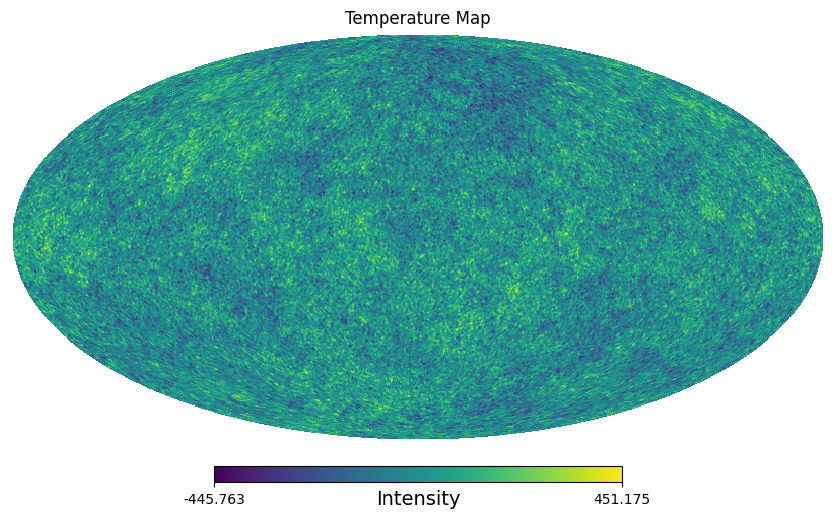

In [3]:
#Read the data
path_lcdm = "./simulated_maps/lcdm/"
map_temp_data = read_map(path_lcdm + 'cmb_map_0.fits')

#Visualize the map
nside = hp.npix2nside(len(map_temp_data))
#nside = 64
print(f"NSIDE: {nside}")

#Plot
hp.mollview(map_temp_data, title="Temperature Map", unit="Intensity")
plt.show()

In [4]:
layers = [hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=2),
          tf.keras.layers.Lambda(lambda x: tf.nn.softmax(tf.reduce_mean(x, axis=1),
                                                         axis=-1))]

In [5]:
indices = np.arange(hp.nside2npix(nside))

In [6]:
tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
batch_size = 16
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

25-05-07 17:59:17  sbi_flows INF   WARNING: This network assumes that everything concerning healpy is in NEST ordering... 
25-05-07 17:59:17  sbi_flows INF   Detected a reduction factor of 8.0, the input with nside 128 will be transformed to 16 during a forward pass. Checking for consistency with indices... 
25-05-07 17:59:17  sbi_flows INF   indices seem consistent... 


2025-05-07 18:00:40.131526: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "healpy_gcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ chebyshev (Chebyshev)                          │ (None, 196608, 5)                   │                  65 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool (HealpyPool)                       │ (None, 49152, 5)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_1 (Chebyshev)                        │ (None, 49152, 5)                    │                 265 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool_1 (HealpyPool)                     │ (None, 12288, 5)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_2 (Chebyshev)                        │ (None, 12288, 5)                    │                 265 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool_2 (HealpyPool)                     │ (None, 3072, 5)                     │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_3 (Chebyshev)                        │ (None, 3072, 2)                     │                 100 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ lambda (Lambda)                                │ (None, 2)                           │                   0 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 695 (2.71 KB)

 Trainable params: 665 (2.60 KB)

 Non-trainable params: 30 (120.00 B)

In [7]:
def read_all_maps(path_lcdm, path_feature, n_maps=100):
    maps = []
    labels = []
    
    #LCDM maps
    for i in range(n_maps):
        map_lcdm = read_map(f"{path_lcdm}cmb_map_{i}.fits")
        maps.append(map_lcdm)
        labels.append(0)  #lcdm
    
    #Feature maps
    for i in range(n_maps):
        map_feature = read_map(f"{path_feature}cmb_map_feature_{i}.fits")
        maps.append(map_feature)
        labels.append(1)  #feature
    
    maps = np.array(maps).astype(np.float32)[..., None]  #Add channel dimension
    labels = np.array(labels).astype(np.int32)
    #print(labels)
    return maps, labels

In [8]:
path_feature = "./simulated_maps/feature/"
x_raw, y_raw = read_all_maps(path_lcdm, path_feature, n_maps=36)

Filename: ./simulated_maps/lcdm/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   


ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4 

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [11]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(x_test, y_test),
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 1.9884 - sparse_categorical_accuracy: 0.4563 - val_loss: 60.1198 - val_sparse_categorical_accuracy: 0.4091
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.8941 - sparse_categorical_accuracy: 0.6156 - val_loss: 47.9529 - val_sparse_categorical_accuracy: 0.4091
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.7181 - sparse_categorical_accuracy: 0.6031 - val_loss: 20.6547 - val_sparse_categorical_accuracy: 0.4091
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.7865 - sparse_categorical_accuracy: 0.4469 - val_loss: 9.0088 - val_sparse_categorical_accuracy: 0.4091
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.7312 - sparse_categorical_accuracy: 0.4375 - val_loss: 4.9888 - val_sparse_categorical_accuracy: 0.4091
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.6782 - sparse_categorical_accuracy: 0.5922 - val_loss: 3.2662 - val_sparse_categorical_accuracy: 0.4091
Epoch 7/100
3/3 ━━━━━━━━

In [12]:
#Function for the probability of classification as LCDM 
def normFeat(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Function for the probability of classification as Feature 
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [13]:
theory = ['LCDM','FT']

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(x_test)):
  X_test_tf = tf.convert_to_tensor([x_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normFeat(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Text(0, 0.5, 'Loss')

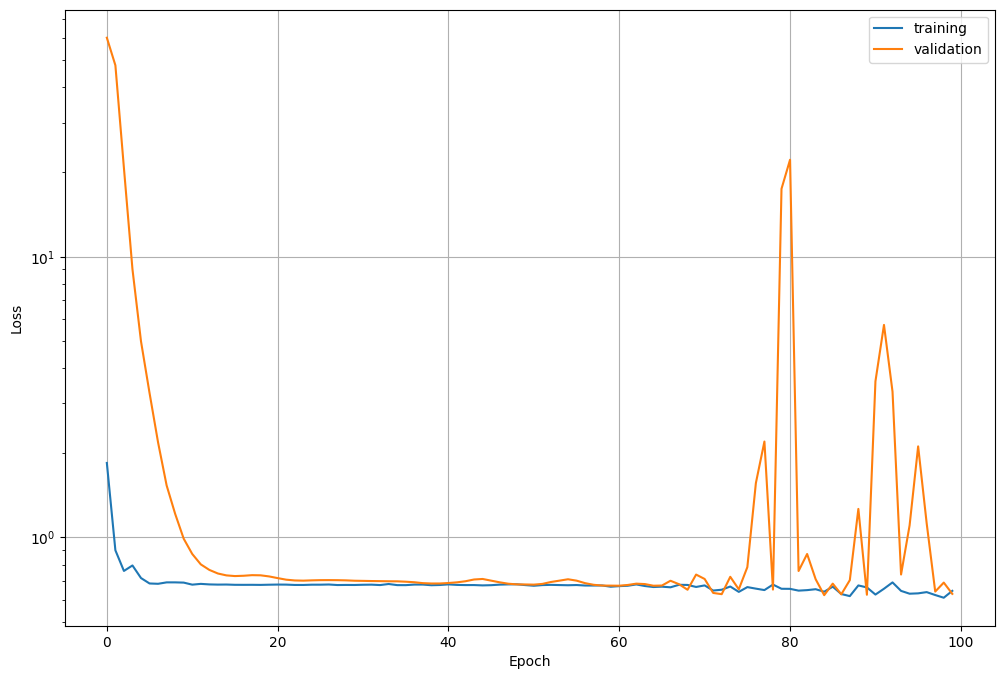

In [14]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [15]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM MoG
True  0.0 0.4090909090909091
False 0.0 0.5909090909090909
--------------
Correct prediction:  0.4090909090909091
Wrong prediction  :  0.5909090909090909
